# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics for the two artists you selected in Module 1 and the Twitter descriptions pulled for Robyn and Cher. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer

In [2]:
# Use this space for any additional import statements you need
import string 

from string import punctuation

In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity (https://en.wikipedia.org/wiki/Lexical_diversity), 
        and num_tokens most common tokens. Return a list with the number of tokens, number
        of unique tokens, lexical diversity, and number of characters. 
    
    """

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    num_characters = sum(len(token) for token in tokens)
    lexical_diversity = num_unique_tokens / num_tokens if num_tokens > 0 else 0

    # find the most common token 
    token_counts = Counter(tokens)
    most_common_tokens = token_counts.most_common(num_tokens)
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        print(f"The {num_tokens} most common tokens are:")
        for token, count in most_common_tokens:
            print(f"'{token}':{count}")
                  
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


def contains_emoji(s):
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]
    return(len(emojis) > 0)


def remove_stop(tokens) :
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word.lower() not in stop_words]

 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))


def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # Remove punctuation characters
    text = remove_punctuation(text)
    
    # modify this function to return tokens
    return text.split()

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)

## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "/Users/samantharivas/Documents/UNIVERSITY OF SAN DIEGO/ADS509/group-comp/M1 Results/" 
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}

In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
# initialize empty dictionary to store the lyrics data
lyrics_data = {}

# iterate over each artist folder
for artist in os.listdir(data_location + lyrics_folder):
    artist_folder = os.path.join(data_location + lyrics_folder, artist)
    if os.path.isdir(artist_folder):  
        artist_lyrics = []
        for song_file in os.listdir(artist_folder):
            song_path = os.path.join(artist_folder, song_file)
            if os.path.isfile(song_path):  
                with open(song_path, 'r', encoding='utf-8') as file:
                    lyrics = file.read()
                    artist_lyrics.append({'artist': artist, 'song': song_file, 'lyrics': lyrics})
        # Create DataFrame for the current artist
        artist_lyrics_df = pd.DataFrame(artist_lyrics)
        lyrics_data[artist] = artist_lyrics_df

for artist, data in lyrics_data.items():
    print(f"Artist: {artist}")
    print(data.head())

Artist: robyn
  artist                    song  \
0  robyn  robyn_includemeout.txt   
1  robyn      robyn_electric.txt   
2  robyn     robyn_beach2k20.txt   
3  robyn     robyn_lovekills.txt   
4  robyn   robyn_timemachine.txt   

                                              lyrics  
0  "Include Me Out"\n\n\n\nIt is really very simp...  
1  "Electric"\n\n\n\nElectric...\n\nIt's electric...  
2  "Beach 2K20"\n\n\n\n(So you wanna go out?\nHow...  
3  "Love Kills"\n\n\n\nIf you're looking for love...  
4  "Time Machine"\n\n\n\nHey, what did I do?\nCan...  
Artist: cher
  artist                        song  \
0   cher  cher_comeandstaywithme.txt   
1   cher             cher_pirate.txt   
2   cher              cher_stars.txt   
3   cher          cher_thesedays.txt   
4   cher         cher_lovesohigh.txt   

                                              lyrics  
0  "Come And Stay With Me"\n\n\n\nI'll send away ...  
1  "Pirate"\n\n\n\nHe'll sail on with the summer ...  
2  "Stars"\n\n\n\nI 

In [8]:
# concatenate df for both artists
lyrics_data = pd.concat(lyrics_data.values(), ignore_index=True)

lyrics_data.sample(20)

,artist,song,lyrics
101,robyn,robyn_missingu.txt,"""Missing U""\n\n\n\nBaby, it's so weird to me n..."
156,cher,cher_iknowyoudontloveme.txt,"""I Know (You Don't Love Me)""\n\n\n\nUh uh uh\n..."
155,cher,cher_thewinnertakesitall.txt,"""The Winner Takes It All""\n\n\n\nI don't wanna..."
237,cher,cher_fireandrain.txt,"""Fire And Rain""\n\n\n\nJust yesterday morning ..."
242,cher,cher_saveupallyourtears.txt,"""Save Up All Your Tears""\n\n\n\nI can't figure..."
301,cher,cher_blowininthewind.txt,"""Blowin' In The Wind""\n\n\n\nHow many roads mo..."
164,cher,cher_heyjoe.txt,"""Hey Joe""\n\n\n\nHey Joe, where you goin'\nWit..."
337,cher,cher_kisstokiss.txt,"""Kiss To Kiss""\n\n\n\nDo nothin' 'til you hear..."
163,cher,cher_red.txt,"""Red""\n\n\n\nAll I see is red, now\nJust can't..."
53,robyn,robyn_dontfuckingtellmewhattodo.txt,"""Don't Fucking Tell Me What To Do""\n\n\n\nMy d..."


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [9]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 

In [10]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [11]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
405671,cher,Full-Time Queen | Nap Enthusiast | Small Artis...,"[fulltime, queen, nap, enthusiast, small, arti..."
3906466,cher,🏵️ Psicologa Clínica. 🌳 Yagé y Tabaco. 🇻🇪 Vene...,"[🏵️, psicologa, clínica, 🌳, yagé, tabaco, 🇻🇪, ..."
453041,cher,20 ⚫️🔴,"[20, ⚫️🔴]"
620247,cher,Divertirme♡🤩,[divertirme♡🤩]
12696,robyn,✨Ilustrador freelancer e cearense✨ele/dele✨con...,"[✨ilustrador, freelancer, e, cearense✨eledele✨..."
3908848,cher,name: kizzie fave song: i'm not dead member of...,"[name, kizzie, fave, song, im, dead, member, p..."
340777,cher,*18✨ *IG:iammakita JSU’25’🐔,"[18✨, igiammakita, jsu’25’🐔]"
226174,robyn,Living life ✌️,"[living, life, ✌️]"
988861,cher,Married with two AMAZING kids. Proud Art Histo...,"[married, two, amazing, kids, proud, art, hist..."
3783627,cher,"happy go lucky, retail manager, Team Mystic ❄️...","[happy, go, lucky, retail, manager, team, myst..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: One way to improve tokenization is by better handling of special cases like contractions and emojis. For example, instead of splitting contractions like "can't" into two tokens ("can" and "'t"), preserving them as single tokens retains the intended meaning and nuances of language. Similarly, preserving emojis and symbols within words ensures that the sentiment and tone of the text are accurately captured during analysis. By addressing both areas, tokenization becomes more accurate and reflective of the original text's context and meaning.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [12]:
lyrics_data.head()

,artist,song,lyrics,tokens,num_tokens
0,robyn,robyn_includemeout.txt,"""Include Me Out""\n\n\n\nIt is really very simp...","[include, really, simple, single, pulse, repea...",234
1,robyn,robyn_electric.txt,"""Electric""\n\n\n\nElectric...\n\nIt's electric...","[electric, electric, electric, natural, high, ...",153
2,robyn,robyn_beach2k20.txt,"""Beach 2K20""\n\n\n\n(So you wanna go out?\nHow...","[beach, 2k20, wanna, go, gonna, get, ok, call,...",174
3,robyn,robyn_lovekills.txt,"""Love Kills""\n\n\n\nIf you're looking for love...","[love, kills, youre, looking, love, get, heart...",246
4,robyn,robyn_timemachine.txt,"""Time Machine""\n\n\n\nHey, what did I do?\nCan...","[time, machine, hey, cant, believe, fit, threw...",129


In [29]:
for artist, songs in lyrics_data.items():
    print(f"Descriptive stats for {artist} (Lyrics data):")
    print(songs.describe())

Descriptive stats for artist (Lyrics data):
count      420
unique       2
top       cher
freq       316
Name: artist, dtype: object
Descriptive stats for song (Lyrics data):
count                        420
unique                       420
top       robyn_includemeout.txt
freq                           1
Name: song, dtype: object
Descriptive stats for lyrics (Lyrics data):
count                                                   420
unique                                                  411
top       "Fembot"\n\n\n\nI've got some news for you\nFe...
freq                                                      2
Name: lyrics, dtype: object
Descriptive stats for tokens (Lyrics data):
count                                                   420
unique                                                  411
top       [fembot, ive, got, news, fembots, feelings, sp...
freq                                                      2
Name: tokens, dtype: object
Descriptive stats for num_tokens (Lyrics dat

In [13]:
cher_stats = lyrics_data[lyrics_data['artist'] == 'cher']['num_tokens'].describe()

print("Descriptive Statistics for Cher's Lyrics:")
print(cher_stats)

Descriptive Statistics for Cher's Lyrics:
count    316.000000
mean     113.658228
std       39.828326
min       22.000000
25%       85.000000
50%      110.000000
75%      137.000000
max      241.000000
Name: num_tokens, dtype: float64


In [14]:
robyn_stats = lyrics_data[lyrics_data['artist'] == 'robyn']['num_tokens'].describe()

print("\nDescriptive Statistics for Robyn's Lyrics:")
print(robyn_stats)


Descriptive Statistics for Robyn's Lyrics:
count    104.000000
mean     146.413462
std       67.615649
min       10.000000
25%       96.750000
50%      137.000000
75%      181.250000
max      351.000000
Name: num_tokens, dtype: float64


Q: what observations do you make about these data? 

A: Robyn's lyrics tend to have more tokens than Cher's lyrics, as indicated by the higher mean token count. This suggests that Robyn's songwriting style may involve more elaborate storytelling or detailed expression. Additionally, there is greater variability in the number of tokens in Robyn's lyrics compared to Cher's, implying a wider range of lyrical complexity and depth in Robyn's songs.

## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [30]:
# define functions

# calculate concentration ratio for each token
def calculate_concentration_ratio(corpus_data, n):
    total_tokens_per_corpus = {corpus: sum(len(tokens) for tokens in corpus_data[corpus]) for corpus in corpus_data}
    token_frequencies_per_corpus = {corpus: Counter(token for tokens in corpus_data[corpus] for token in tokens) for corpus in corpus_data}

    concentration_ratios = {}
    
    #iterate over each corpus
    for corpus, frequencies in token_frequencies_per_corpus.items():
        other_corpora = [other_corpus for other_corpus in corpus_data if other_corpus != corpus]
        other_total_tokens = sum(total_tokens_per_corpus[other_corpus] for other_corpus in other_corpora)
        
        # calculate concentration ratio for each token
        for token, frequency in frequencies.items():
            if frequency >= n:
                concentration_ratio = frequency / (total_tokens_per_corpus[corpus] + other_total_tokens)
                concentration_ratios[(corpus, token)] = concentration_ratio
    
    return concentration_ratios

# top 10 tokens for each corpus based on concentration ratio
def find_top_tokens(corpus_data, n, top_n=10):
    concentration_ratios = calculate_concentration_ratio(corpus_data, n)
    sorted_tokens = sorted(concentration_ratios.items(), key=lambda x: x[1], reverse=True)
    
    # filter top tokens for each corpus
    top_tokens_per_corpus = {}
    for corpus in corpus_data:
        top_tokens_per_corpus[corpus] = [(token, ratio) for (corp, token), ratio in sorted_tokens if corp == corpus][:top_n]
    
    return top_tokens_per_corpus

In [31]:
# convert df to dictionary of tokenized lyrics
corpus_data = {}
for artist, group in lyrics_data.groupby('artist'):
    corpus_data[artist] = group['tokens'].tolist()

In [32]:
# define parameters
n = 5  
top_n = 10  

# find top tokens
top_tokens = find_top_tokens(corpus_data, n, top_n)

for corpus, tokens in top_tokens.items():
    print(f"Top tokens for {corpus}:")
    for token, ratio in tokens:
        print(f"{token}: {ratio}")

Top tokens for cher:
love: 0.019631230080362903
im: 0.010030698238273078
know: 0.009502766752048178
dont: 0.008603327923665017
youre: 0.006511154996773752
time: 0.0062374127446571375
baby: 0.0062374127446571375
see: 0.006022329546565512
oh: 0.005983223510548853
one: 0.005513951078348943
Top tokens for robyn:
know: 0.006022329546565512
dont: 0.005885458420507205
im: 0.005846352384490546
love: 0.005377079952290636
got: 0.004907807520090726
like: 0.004536300177932464
baby: 0.004340769997849168
youre: 0.0033044600434077
never: 0.0030307177912910857
dance: 0.002932952701249438


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The top tokens from Cher's and Robyn's lyrics shows that both artists frequently use words like "love," "im," "know," and "dont," indicating common themes of love and self-expression. Cher's unique tokens like "time," "see," and "one" suggest a more narrative or reflective style opposed to Robyn's unique tokens like "got," "like," and "dance" which reflect a pop focus on movement and rhythm. The top tokens reveal shared themes of emotions and personal experiences, with a distinct differences in style and focus between the two artists.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [33]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [34]:
robyn_freq = count_words(lyrics_data[lyrics_data['artist'] == 'robyn'])
cher_freq = count_words(lyrics_data[lyrics_data['artist'] == 'cher'])

In [41]:
robyn_freq.head(10)

,freq
token,
know,308
dont,301
im,299
love,275
got,251
like,232
baby,222
youre,169
never,155


In [42]:
cher_freq.head(10)

,freq
token,
love,1004
im,513
know,486
dont,440
youre,333
time,319
baby,319
see,308
oh,306


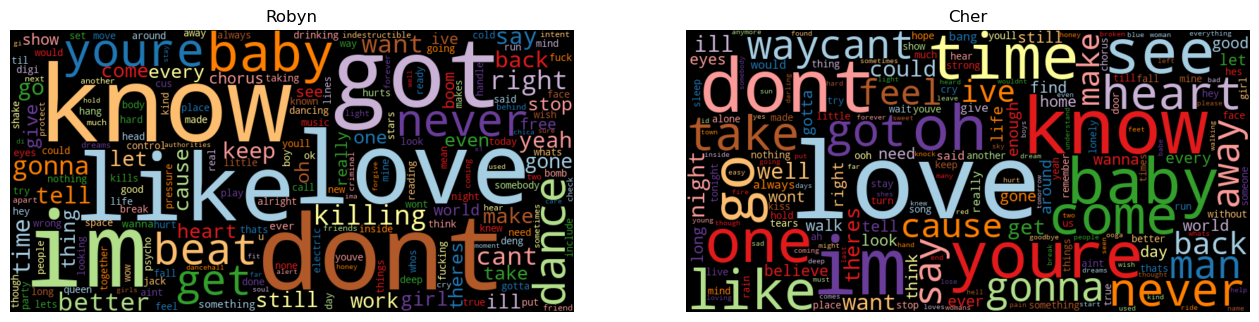

In [35]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
wordcloud(robyn_freq['freq'], title="Robyn")

plt.subplot(1, 2, 2)
wordcloud(cher_freq['freq'], title="Cher")

plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: The word clouds reveal that both Robyn and Cher frequently use words related to love and personal experiences, such as "love," "know," "don't," and "I'm." This indicates a common focus on themes of relationships and self-expression. Robyn's lyrics also prominently feature terms like "dance" and "beat," underscoring her dance-pop genre's emphasis on rhythm/movement. Rather Cher's lyrics include words like "time," "see," and "oh," reflecting a broader range of narrative and emotional elements. The differences highlight Robyn's focus on energetic, danceable content, whereas Cher's lyrics delve more into storytelling and varied emotional expressions.